#### Imports

In [1]:
import wrangle
import explore
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:20,.2f}'.format

from math import sqrt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

#### Import LA Dataframe For Explore

In [2]:
df = wrangle.get_zillow_data(cached=True)
df_la, df_v, df_o = wrangle.clean_zillow_data(df)
X_train, X_validate, X_test, X_train_explore, y_train, y_validate, y_test, X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.split_scale(df_la)

In [3]:
X_train.shape, X_validate.shape, X_test.shape, y_train.shape

((18756, 13), (8039, 13), (6699, 13), (18756, 1))

# Exploration:

**Target = Logerror** 


-A number that represents a ratio that is derived from two prior distributions - the real price distribution of homes and then Zillow's existing model of that distribution

In [4]:
X_train_explore.head()

,logerror,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
50028,0.03,3.00,"2,313.00",34.16,-118.42,1,0,0,55.00,0.01,0.16,151.44,72.58,1.33
16721,-0.02,1.00,"1,232.00",34.23,-118.25,1,0,0,91.00,0.01,0.17,18.40,13.69,3.00
30822,0.07,1.00,"1,213.00",34.03,-118.46,1,0,0,66.00,0.01,0.13,91.47,141.76,3.00
4398,0.03,2.00,"1,920.00",34.02,-118.32,1,0,0,95.00,0.01,0.13,62.68,41.50,1.50
46912,-0.01,2.00,"1,268.00",33.91,-118.13,1,0,0,63.00,0.02,0.12,28.23,5.11,1.50


#### Inital Thoughts:

- From my inital investigation on regression project I know that room count has a large affect on taxrate and housing price.  I was unable to create a derived feature last go round so I want to test the affect of this feature now.     

- I want to examine how usefull our created feature of bedbathratio is in predicting logerror in LA County.  I chose LA County because it has the largest number of datapoints.  I want to cluster on bedbathratio, bathroomcnt, and caluculaedfinishedsquarefeet.   

## Cluster One: Room Clusters

### Step 1. Elbow Plot

   k                  sse
0  1               492.58
1  2               245.24
2  3               152.44
3  4               107.41
4  5                71.00
5  6                59.45
6  7                48.26
7  8                38.27
8  9                31.17


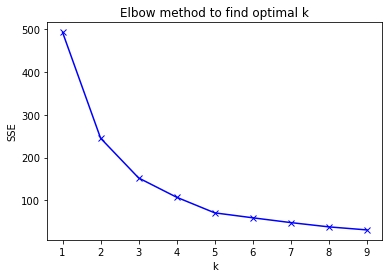

In [5]:
cluster_vars = ['bathroomcnt', 'bed_bath_ratio', 'calculatedfinishedsquarefeet']
explore.elbow_plot(X_train_scaled, cluster_vars)

#### Takeaway:

- Lets try 4 
***

### Step 2. Create Clusters

#### 2a. Train Cluster

In [6]:
train_clusters, kmeans = explore.run_kmeans(X_train, X_train_scaled, k=4, cluster_vars=cluster_vars, cluster_col_name = 'room_cluster')

In [7]:
train_clusters

,room_cluster
50028,3
16721,1
30822,1
4398,3
46912,3
...,...
39988,3
19901,3
51300,3
50259,2


In [8]:
#Visualize distribution of clusters, they do not look even
train_clusters.room_cluster.value_counts()

3    10685
2     4561
1     1957
0     1553
Name: room_cluster, dtype: int64

#### 2b. Get Centroids

In [9]:
centroid_col_names = ['centroid_' + i for i in cluster_vars]
centroid_col_names

centroids = pd.DataFrame(kmeans.cluster_centers_, 
             columns=centroid_col_names).reset_index().rename(columns={'index': 'room_cluster'})

In [10]:
centroids

,room_cluster,centroid_bathroomcnt,centroid_bed_bath_ratio,centroid_calculatedfinishedsquarefeet
0,0,0.42,0.20,0.18
1,1,0.09,0.61,0.05
2,2,0.13,0.40,0.05
3,3,0.21,0.27,0.08


#### 2c. Append cluster id onto X_train & X_train_scaled, then join with the centroids dataframe.


In [11]:
# concatenate cluster id on LA_X_Train
X_train = pd.concat([X_train, train_clusters], axis=1)

In [12]:
X_train.head()

,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,room_cluster
50028,3.00,"2,313.00",34.16,-118.42,1,0,0,55.00,0.01,0.16,151.44,72.58,1.33,3
16721,1.00,"1,232.00",34.23,-118.25,1,0,0,91.00,0.01,0.17,18.40,13.69,3.00,1
30822,1.00,"1,213.00",34.03,-118.46,1,0,0,66.00,0.01,0.13,91.47,141.76,3.00,1
4398,2.00,"1,920.00",34.02,-118.32,1,0,0,95.00,0.01,0.13,62.68,41.50,1.50,3
46912,2.00,"1,268.00",33.91,-118.13,1,0,0,63.00,0.02,0.12,28.23,5.11,1.50,3


In [13]:
# join on clusterid to get centroids
X_train = X_train.merge(centroids, how='left', on='room_cluster').set_index(X_train.index)

In [14]:
X_train.head()

,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,room_cluster,centroid_bathroomcnt,centroid_bed_bath_ratio,centroid_calculatedfinishedsquarefeet
50028,3.00,"2,313.00",34.16,-118.42,1,0,0,55.00,0.01,0.16,151.44,72.58,1.33,3,0.21,0.27,0.08
16721,1.00,"1,232.00",34.23,-118.25,1,0,0,91.00,0.01,0.17,18.40,13.69,3.00,1,0.09,0.61,0.05
30822,1.00,"1,213.00",34.03,-118.46,1,0,0,66.00,0.01,0.13,91.47,141.76,3.00,1,0.09,0.61,0.05
4398,2.00,"1,920.00",34.02,-118.32,1,0,0,95.00,0.01,0.13,62.68,41.50,1.50,3,0.21,0.27,0.08
46912,2.00,"1,268.00",33.91,-118.13,1,0,0,63.00,0.02,0.12,28.23,5.11,1.50,3,0.21,0.27,0.08


#### 2d. Visualize room_clusters and centroids 

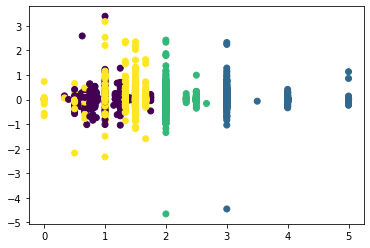

In [15]:
# Visualize 
plt.scatter(X_train.bed_bath_ratio, y_train.logerror, c=X_train.room_cluster)
plt.show()

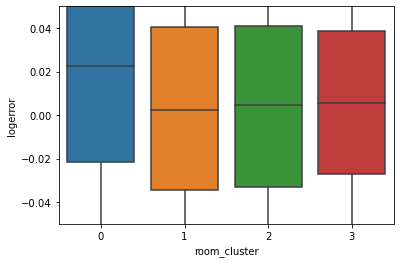

In [16]:
sns.boxplot(X_train.room_cluster, y_train.logerror)
plt.ylim(-.05,.05)
plt.show()

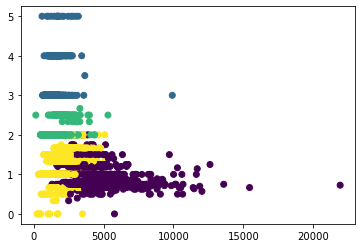

In [37]:
plt.scatter(X_train.calculatedfinishedsquarefeet, X_train.bed_bath_ratio, c=X_train.room_cluster)
plt.show()

## Cluster Two: Size Clusters

- calculatedfinishedsquarefeet
- acres
- structure_dollar_per_sqft
- land_dollar_per_sqft

### Step 1. Elbow Plot

   k                  sse
0  1               108.02
1  2                76.69
2  3                62.47
3  4                53.76
4  5                47.30
5  6                41.53
6  7                36.89
7  8                32.90
8  9                29.96


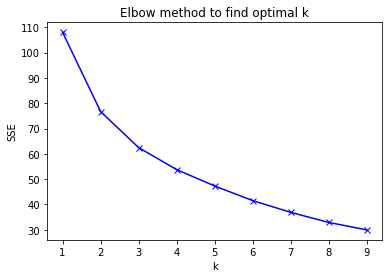

In [18]:
cluster_vars = ['calculatedfinishedsquarefeet', 'acres', 'structure_dollar_per_sqft', 'land_dollar_per_sqft']
explore.elbow_plot(X_train_scaled, cluster_vars)

**Takeaway:**

**K of 3 looks good here**

***

### Step 2. Create Clusters

#### 2a. Train Cluster

In [19]:
train_clusters, kmeans = explore.run_kmeans(X_train, X_train_scaled, k=3, cluster_vars=cluster_vars, cluster_col_name = 'size_cluster')

In [20]:
train_clusters

,size_cluster
50028,1
16721,0
30822,0
4398,0
46912,0
...,...
39988,1
19901,0
51300,0
50259,0


In [21]:
#Visualize distribution of clusters, they do not look even
train_clusters.size_cluster.value_counts()

0    14640
1     3619
2      497
Name: size_cluster, dtype: int64

#### 2b. Get Centroids

In [22]:
centroid_col_names = ['centroid_' + i for i in cluster_vars]
centroid_col_names

centroids = pd.DataFrame(kmeans.cluster_centers_, 
             columns=centroid_col_names).reset_index().rename(columns={'index': 'size_cluster'})

In [23]:
centroids

,size_cluster,centroid_calculatedfinishedsquarefeet,centroid_acres,centroid_structure_dollar_per_sqft,centroid_land_dollar_per_sqft
0,0,0.06,0.00,0.05,0.02
1,1,0.14,0.00,0.08,0.03
2,2,0.14,0.00,0.22,0.16


#### 2c. Append cluster id onto X_train & X_train_scaled, then join with the centroids dataframe.

In [24]:
# concatenate cluster id on LA_X_Train
X_train = pd.concat([X_train, train_clusters], axis=1)

In [25]:
X_train.head()

,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,room_cluster,centroid_bathroomcnt,centroid_bed_bath_ratio,centroid_calculatedfinishedsquarefeet,size_cluster
50028,3.00,"2,313.00",34.16,-118.42,1,0,0,55.00,0.01,0.16,151.44,72.58,1.33,3,0.21,0.27,0.08,1
16721,1.00,"1,232.00",34.23,-118.25,1,0,0,91.00,0.01,0.17,18.40,13.69,3.00,1,0.09,0.61,0.05,0
30822,1.00,"1,213.00",34.03,-118.46,1,0,0,66.00,0.01,0.13,91.47,141.76,3.00,1,0.09,0.61,0.05,0
4398,2.00,"1,920.00",34.02,-118.32,1,0,0,95.00,0.01,0.13,62.68,41.50,1.50,3,0.21,0.27,0.08,0
46912,2.00,"1,268.00",33.91,-118.13,1,0,0,63.00,0.02,0.12,28.23,5.11,1.50,3,0.21,0.27,0.08,0


In [27]:
# join on clusterid to get centroids
X_train = X_train.merge(centroids, how='left', on='size_cluster').set_index(X_train.index)

In [28]:
X_train.head()

,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,LA,Orange,Ventura,age,taxrate,acres,...,bed_bath_ratio,room_cluster,centroid_bathroomcnt,centroid_bed_bath_ratio,centroid_calculatedfinishedsquarefeet_x,size_cluster,centroid_calculatedfinishedsquarefeet_y,centroid_acres,centroid_structure_dollar_per_sqft,centroid_land_dollar_per_sqft
50028,3.00,"2,313.00",34.16,-118.42,1,0,0,55.00,0.01,0.16,...,1.33,3,0.21,0.27,0.08,1,0.14,0.00,0.08,0.03
16721,1.00,"1,232.00",34.23,-118.25,1,0,0,91.00,0.01,0.17,...,3.00,1,0.09,0.61,0.05,0,0.06,0.00,0.05,0.02
30822,1.00,"1,213.00",34.03,-118.46,1,0,0,66.00,0.01,0.13,...,3.00,1,0.09,0.61,0.05,0,0.06,0.00,0.05,0.02
4398,2.00,"1,920.00",34.02,-118.32,1,0,0,95.00,0.01,0.13,...,1.50,3,0.21,0.27,0.08,0,0.06,0.00,0.05,0.02
46912,2.00,"1,268.00",33.91,-118.13,1,0,0,63.00,0.02,0.12,...,1.50,3,0.21,0.27,0.08,0,0.06,0.00,0.05,0.02


#### 2d. Visualize room_clusters and centroids 

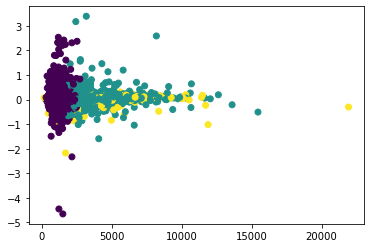

In [29]:
plt.scatter(X_train.calculatedfinishedsquarefeet, y_train.logerror, c=X_train.size_cluster)
plt.show()

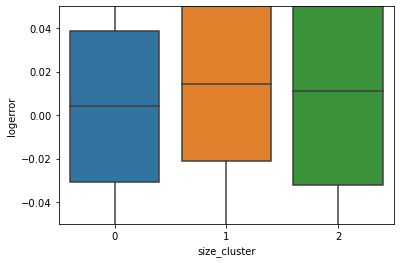

In [30]:
sns.boxplot(X_train.size_cluster, y_train.logerror)
plt.ylim(-.05,.05)
plt.show()

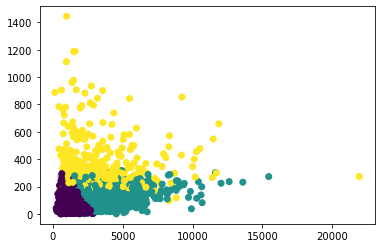

In [33]:
plt.scatter(X_train.calculatedfinishedsquarefeet, X_train.structure_dollar_per_sqft, c=X_train.size_cluster)
plt.show()

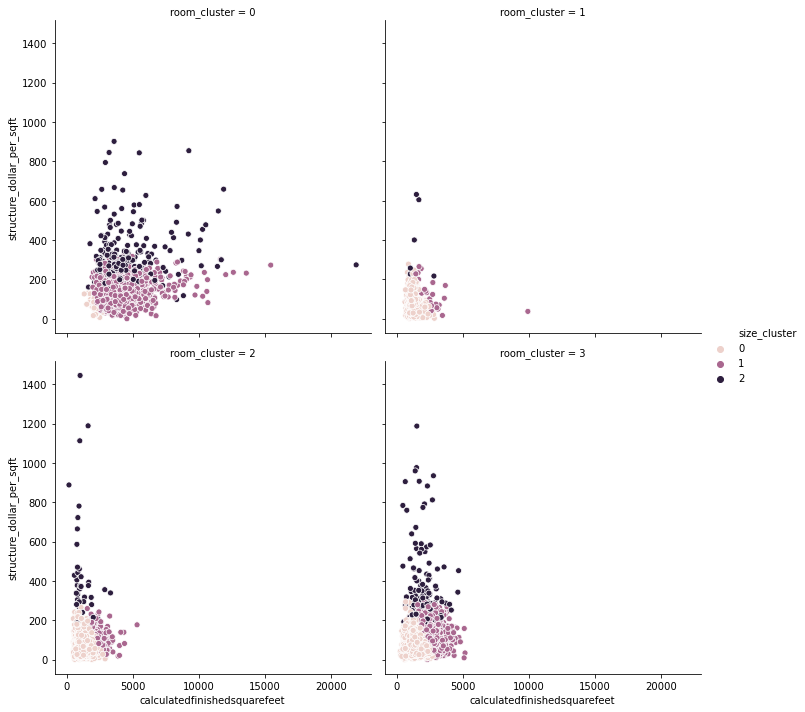

In [36]:
# visualize w/ hue="species" style="cluster"
sns.relplot(x="calculatedfinishedsquarefeet", y="structure_dollar_per_sqft", hue="size_cluster", col="room_cluster", col_wrap=2, data=X_train)
plt.show()